In [1]:
import ast
import bs4
import time
import json
import requests
import pandas as pd
import scipy as scipy
import numpy as np
from bs4 import BeautifulSoup
from datetime import datetime
import matplotlib.pyplot as plt

%matplotlib inline

In [100]:
df = pd.read_csv('canna_df.csv')
df['Feelings'] = df['Feelings'].map(ast.literal_eval) ## To get dicts instead of strings
df['Cannabinoids'] = df['Cannabinoids'].map(ast.literal_eval)

In [101]:
## Open dictionaries in columns ['Feelings','Cannabinoids'] to columns

df = df.reset_index(drop=True)


for i in range(5): 
    df[f'Feeling_{i+1}'] = df.apply(lambda x: x['Feelings']['Feelings'][i],axis=1) ## Turn feelings list to columns
    df[f'Negative_{i+1}'] = df.apply(lambda x: x['Feelings']['Negatives'][i],axis=1) ## Turn negative feelings list to columns
    df[f'Helps with_{i+1}'] = df.apply(lambda x: x['Feelings']['Helps with'][i],axis=1) ## Turn helps with list to columns

    df[f'Feeling_{i+1}'] = df[f'Feeling_{i+1}'].str.replace(r'\b $','',regex=True) ## Remove space at the end of values
    df[f'Negative_{i+1}'] = df[f'Negative_{i+1}'].str.replace(r'\b $','',regex=True)
    df[f'Helps with_{i+1}'] = df[f'Helps with_{i+1}'].str.replace(r'\b $','',regex=True)


df['THC'] = df.apply(lambda x: x['Cannabinoids']['THC'],axis=1) ## Turn Cannabinoid dict to columns
df['CBD'] = df.apply(lambda x: x['Cannabinoids']['CBD'],axis=1) 
df['CBG'] = df.apply(lambda x: x['Cannabinoids']['CBG'],axis=1) 


df.drop(['Feelings','Cannabinoids'],inplace=True,axis=1) ## Remove old columns

cols = ['Rating','Rating Users','THC','CBD','CBG']

df['THC'] = df['THC'].str.replace("%",'',regex=True) # Remove % from numbers
df['CBD'] = df['CBD'].str.replace("%",'',regex=True)
df['CBG'] = df['CBG'].str.replace("%",'',regex=True)


df['CBD'].replace("—",np.nan,regex=True,inplace=True) # Replace '-' values with NaN
df['THC'].replace("—",np.nan,regex=True,inplace=True)
df['CBG'].replace("—",np.nan,regex=True,inplace=True)

df[cols] = df[cols].apply(pd.to_numeric) # Change columns type to numeric





In [95]:
df['Type'].value_counts()

Hybrid    3014
Indica     836
Sativa     520
Name: Type, dtype: int64

In [102]:
## Fill missing THC values

def my_func(df,parent):

    func_df = df.loc[(df['Left Parent'] == parent) | (df['Right parent'] == parent) | (df['Strain Name'] == parent)] ## All rows with same parent, including the parent
    mean = round(func_df['THC'].mean(),0)

    return mean

def complete_cannabinoids_nan(df,col_names):
    
    fixed_df = []

    for col in col_names:
        try:
            nanim = df[(df[f'{col}'].isna()) & ((df['Left Parent'].notna()) | (df['Right parent'].notna()))].copy() # To apply changes on real DF

            nanim[f'{col}'] = nanim.apply(lambda x: my_func(df,x['Left Parent']),axis=1)
            nanim[f'{col}'] = nanim.apply(lambda x: my_func(df,x['Right parent']) if pd.isnull(x[f'{col}']) else x[f'{col}'],axis=1)
            fixed_df.append(nanim)
        except Exception as e:
            print(f'Didnt get data for {col_name}')
            pass


    fixed_df = pd.concat(fixed_df)

    return fixed_df






In [48]:
df[df['CBD'].isna()]

,Unnamed: 0,Strain Name,Type,Rating,Rating Users,Left Parent,Right parent,Left Child,Right Child,Feeling_0,...,Helps with_2,Feeling_3,Negative_3,Helps with_3,Feeling_4,Negative_4,Helps with_4,THC,CBD,CBG
0,0,Mega Jackpot,Hybrid,4.1,19.0,Jack Herer,Northern Lights,NaN,NaN,Relaxed,...,Anxiety,Creative,None,Nausea,Talkative,None,Stress,18.0,NaN,1.0
1,1,Versace,Hybrid,4.8,30.0,OG Kush,Sour Diesel,NaN,NaN,Relaxed,...,Fatigue,Focused,Headache,Pain,Euphoric,Anxious,Headaches,14.0,NaN,NaN
2,2,Y Life,Hybrid,4.0,2.0,NaN,NaN,NaN,NaN,Uplifted,...,None,None,None,None,None,None,None,NaN,NaN,NaN
3,3,Purple Reign,Hybrid,4.2,17.0,NaN,NaN,NaN,NaN,Relaxed,...,Anxiety,Tingly,None,None,Focused,None,None,NaN,NaN,NaN
4,4,Black Haze,Hybrid,4.4,43.0,Purple Haze,Colombian Gold,NaN,NaN,Relaxed,...,Stress,Uplifted,Dizzy,Depression,Creative,Headache,Lack of appetite,15.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5157,5157,G Purps,NaN,3.6,11.0,NaN,NaN,NaN,NaN,None,...,None,None,None,None,None,None,None,NaN,NaN,NaN
5158,5158,Snow Daze,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,...,None,None,None,None,None,None,None,14.0,NaN,1.0
5159,5159,1024,Sativa,4.5,61.0,NaN,NaN,NaN,NaN,Uplifted,...,Anxiety,Relaxed,None,Depression,Creative,None,Inflammation,10.0,NaN,1.0
5160,5160,Red Velvet Pie,Hybrid,5.0,11.0,Cherry Pie,NaN,NaN,NaN,Happy,...,Stress,Giggly,None,None,Relaxed,None,None,21.0,NaN,NaN


In [103]:

nanim_df = complete_cannabinoids_nan(df,['THC','CBD','CBG'])


In [104]:
df = df.copy()
df.update(nanim_df)

In [105]:
df.columns.str.match("Unnamed") ## A new column was created from some reason
df = df.loc[:,~df.columns.str.match("Unnamed")]



In [99]:


# curr_df = df[(df['Feeling_1'].isna()) & (df['Feeling_2'].isna()) & (df['Feeling_3'].isna())]
curr_df = df[(df['Feeling_1'].isnull()) & (df['Feeling_2'].isnull()) & (df['Feeling_3'].isnull()) & ((df['Left Parent'].notna()) | (df['Right parent'].notna()))]
# curr_df = df[(df['Negative_1'].isnull()) & (df['Negative_2'].isnull()) & (df['Negative_3'].isnull())]

# curr_df.shape
curr_df.head(10)


,Unnamed: 0,Strain Name,Type,Rating,Rating Users,Left Parent,Right parent,Left Child,Right Child,Feeling_1,...,Helps with_3,Feeling_4,Negative_4,Helps with_4,Feeling_5,Negative_5,Helps with_5,THC,CBD,CBG
8,8,Stashsquatch,Hybrid,NaN,NaN,GSC,True OG,Lemon Stash CBD,Lazy Susan CBD,None,...,None,None,None,None,None,None,None,NaN,NaN,NaN
17,17,Dosi OG,Hybrid,NaN,NaN,OG Kush,Do-Si-Dos,NaN,NaN,None,...,None,None,None,None,None,None,None,21.0,NaN,1.0
37,37,Sugartown Express,Hybrid,NaN,NaN,Purple Trainwreck,NaN,NaN,NaN,None,...,None,None,None,None,None,None,None,NaN,NaN,NaN
46,46,Hot Cakes,Hybrid,4.0,2.0,Wedding Cake,Strawberry Shortcake,NaN,NaN,None,...,None,None,None,None,None,None,None,NaN,NaN,NaN
67,67,Ivan,Hybrid,NaN,NaN,GG4,Granddaddy Purple,NaN,NaN,None,...,None,None,None,None,None,None,None,NaN,NaN,NaN
73,73,Lemon Tangie,Hybrid,5.0,3.0,SFV OG,Tangie,NaN,NaN,None,...,None,None,None,None,None,None,None,19.0,NaN,NaN
78,78,Actual Pain,Hybrid,NaN,NaN,Papaya,Black Domina,NaN,NaN,None,...,None,None,None,None,None,None,None,19.0,NaN,1.0
106,106,Tangenesia,Hybrid,5.0,1.0,Tangerine Haze,NaN,NaN,NaN,None,...,None,None,None,None,None,None,None,16.0,NaN,1.0
154,154,F'n louZER,Indica,NaN,NaN,White Rhino,Bloo's Kloos,NaN,NaN,None,...,None,None,None,None,None,None,None,NaN,NaN,NaN
187,187,Phone Home,Hybrid,5.0,1.0,Strawberry Banana,NaN,NaN,NaN,None,...,None,None,None,None,None,None,None,22.0,NaN,1.0


In [166]:
def my_func2(df,parent,mode,col):

    func_df = df.loc[(df['Left Parent'] == parent) | (df['Right parent'] == parent) | (df['Strain Name'] == parent)] ## All rows with same parent, including the parent

    if mode == 'Feelings':
        try:
            feeling = func_df[col].value_counts().idxmax()
            
            return feeling

        except Exception as e:
            feeling = np.NaN

    elif mode == 'Cannabinoids':

        mean = round(func_df[col].mean(),0)
        return mean



def complete_feelings(df,col_names):
    
    
    
    for i,col in enumerate(col_names,0):
        if any('Feeling' in s for s in cols):
            nanim = df[(df['Feeling_1'].isnull()) & (df['Feeling_2'].isnull()) & (df['Feeling_3'].isnull()) & ((df['Left Parent'].notna()) | (df['Right parent'].notna()))]
            mode = 'Feelings'

        # elif any('Negative' in s for s in cols):
        #     nanim = df[(df['Negative_1'].isnull()) & (df['Negative_2'].isnull()) & (df['Negative_3'].isnull()) & ((df['Left Parent'].notna()) | (df['Right parent'].notna()))]
        # elif any('Helps with' in s for s in cols):
        #     nanim = df[(df['Helps with_1'].isnull()) & (df['Helps with_2'].isnull()) & (df['Helps with_3'].isnull()) & ((df['Left Parent'].notna()) | (df['Right parent'].notna()))]
    
        # else:
        #     nanim = df[(df[f'{col}'].isna()) & ((df['Left Parent'].notna()) | (df['Right parent'].notna()))].copy() # To apply changes on real DF
        #     mode = 'Cannabinoids'
        
        try:
            
            nanim[col] = nanim.apply(lambda x: my_func2(df,x['Left Parent'],mode,col),axis=1)
            nanim[col] = nanim.apply(lambda x: my_func2(df,x['Right parent'],mode,col) if pd.isnull(x[col]) else x[col],axis=1)
            if i == 0:
                main_df = nanim
            else:
                main_df.fillna(nanim)

        except Exception as e:
            print(e)
            pass


    return nanim

In [173]:
# cols = ['Feeling_1','Fas']

# if any('Feeling' in s for s in cols):
#     print('Si')

cols = ['Feelings_1','Feelings_2','Feelings_3']

Si


In [167]:
feelings_complete = complete_feelings(df)

In [170]:
# curr_df = df[(df['Feeling_1'].isnull()) & (df['Feeling_2'].isnull()) & (df['Feeling_3'].isnull()) & ((df['Left Parent'].notna()) | (df['Right parent'].notna()))]
feelings_complete.head(15)
# feelings_complete.shape

,Strain Name,Type,Rating,Rating Users,Left Parent,Right parent,Left Child,Right Child,Feeling_1,Negative_1,...,Helps with_3,Feeling_4,Negative_4,Helps with_4,Feeling_5,Negative_5,Helps with_5,THC,CBD,CBG
8,Stashsquatch,Hybrid,NaN,NaN,GSC,True OG,Lemon Stash CBD,Lazy Susan CBD,Relaxed,None,...,None,None,None,None,None,None,None,NaN,NaN,19.0
17,Dosi OG,Hybrid,NaN,NaN,OG Kush,Do-Si-Dos,NaN,NaN,Relaxed,None,...,None,None,None,None,None,None,None,21.0,NaN,1.0
37,Sugartown Express,Hybrid,NaN,NaN,Purple Trainwreck,NaN,NaN,NaN,Uplifted,None,...,None,None,None,None,None,None,None,NaN,NaN,18.0
46,Hot Cakes,Hybrid,4.0,2.0,Wedding Cake,Strawberry Shortcake,NaN,NaN,Relaxed,None,...,None,None,None,None,None,None,None,NaN,NaN,20.0
67,Ivan,Hybrid,NaN,NaN,GG4,Granddaddy Purple,NaN,NaN,Relaxed,None,...,None,None,None,None,None,None,None,NaN,NaN,20.0
73,Lemon Tangie,Hybrid,5.0,3.0,SFV OG,Tangie,NaN,NaN,Relaxed,None,...,None,None,None,None,None,None,None,19.0,NaN,21.0
78,Actual Pain,Hybrid,NaN,NaN,Papaya,Black Domina,NaN,NaN,Happy,None,...,None,None,None,None,None,None,None,19.0,NaN,1.0
106,Tangenesia,Hybrid,5.0,1.0,Tangerine Haze,NaN,NaN,NaN,Happy,None,...,None,None,None,None,None,None,None,16.0,NaN,1.0
154,F'n louZER,Indica,NaN,NaN,White Rhino,Bloo's Kloos,NaN,NaN,Relaxed,None,...,None,None,None,None,None,None,None,NaN,NaN,17.0
187,Phone Home,Hybrid,5.0,1.0,Strawberry Banana,NaN,NaN,NaN,Relaxed,None,...,None,None,None,None,None,None,None,22.0,NaN,1.0


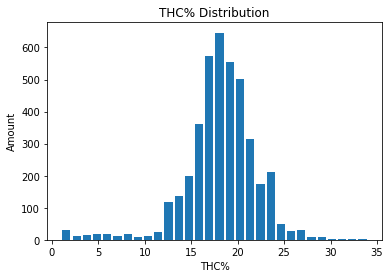

In [22]:
df['THC'].hist(bins=30,rwidth=0.8,grid=False)
plt.xlabel('THC%')
plt.ylabel('Amount')
plt.title('THC% Distribution')
plt.show()

In [ ]:

most_freq1 = df['Feeling_1'].value_counts()[:5].sort_index(ascending=True)
most_freq2 = df['Feeling_2'].value_counts()[:5].sort_index(ascending=True)
most_freq3 = df['Feeling_3'].value_counts()[:5].sort_index(ascending=True)


freq = most_freq1 + most_freq2 + most_freq3


freq.plot(kind='pie')
plt.title('Top 5 Feelings')
plt.show()

In [ ]:
## Top health conditions

most_freq1 = df['Helps with_1'].value_counts()[:5].sort_index(ascending=True)
most_freq2 = df['Helps with_2'].value_counts()[:5].sort_index(ascending=True)
most_freq3 = df['Helps with_3'].value_counts()[:5].sort_index(ascending=True)


freq = most_freq1 + most_freq2 + most_freq3


freq.plot(kind='bar')
plt.show()